# Hypothesis Testing
## 1. Hypothesis Definition

This project aim to evaluate whether there's a correlation between student's AI Usage and their Academic Performance

- H₀ (Null): There is no significant relationship between AI usage and academic performance.
- H₁ (Alternative): There is a significant relationship between AI usage and academic performance.

This hypothesis will be tested using the Pearson correlation coefficient, focusing on Total AI Usage in minutes and student CGPA. If a significant correlation is found, it may guide the development of machine learning models to predict academic performance based on AI usage behaviour, enabling further exploration into how different levels of AI engagement contribute to variations in students’ academic outcomes.

## 2. Load Data
This section is to import the necessary Python libraries and loading our main dataset which is the Performance - AI Usage Relation dataset and other Dataset Enrichment that have been done in EDA. We also include the same data cleaning method as we did in EDA.

In [7]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the datasets
df = pd.read_csv("data/perf_ai.csv")
df['Department'] = df['Department'].replace({'EXTC': 'Engineering', 'IT' : 'Business', 'Comp': 'CS'})

# If Duration exists, force Frequency to at least 1
mask1 = (df['ChatGPT_Usage_Frequency_Per_Week'] == 0) & (df['Average_Session_Duration_Minutes'] > 0)
df.loc[mask1, 'ChatGPT_Usage_Frequency_Per_Week'] = 1

# If Frequency exists, fill 0 Duration with the Median of non-zero durations
median_duration = df[df['Average_Session_Duration_Minutes'] > 0]['Average_Session_Duration_Minutes'].median()

mask2 = (df['ChatGPT_Usage_Frequency_Per_Week'] > 0) & (df['Average_Session_Duration_Minutes'] == 0)
df.loc[mask2, 'Average_Session_Duration_Minutes'] = median_duration

df['Total_AI_Time'] = df['ChatGPT_Usage_Frequency_Per_Week'] * df['Average_Session_Duration_Minutes']
df['Avg_CGPA_by_Dept'] = df.groupby('Department')['CGPA'].transform('mean')
df['Relative_CGPA'] = df['CGPA'] - df['Avg_CGPA_by_Dept']

df_enrich=pd.read_csv("data/stud_performance.csv")
df_enrich = df_enrich.rename(columns={'Stress_Level (1-10)':'Avg_Stress_Level_Dept'}).reset_index()
df_enrich = df_enrich.rename(columns={'Total_Score':'Benchmark_CGPA'}).reset_index()
df_enrich = df_enrich[['Department', 'Avg_Stress_Level_Dept', 'Benchmark_CGPA']]

# Normalize Benchmark_CGPA to a 10-point CGPA scale
df_enrich['Benchmark_CGPA'] = df_enrich['Benchmark_CGPA'] / 9.5

df_enrich_grouped = df_enrich.groupby('Department').agg({
    'Benchmark_CGPA':'mean',
    'Avg_Stress_Level_Dept':'mean'
}).reset_index()

merged_df = pd.merge(df, df_enrich_grouped, left_on='Department', right_on='Department')
print(merged_df.head())

   StudentID   Department  CGPA  ChatGPT_Usage_Frequency_Per_Week  \
0          1  Engineering  7.55                                 2   
1          2     Business  7.23                                17   
2          3  Engineering  8.11                                13   
3          4  Engineering  6.65                                17   
4          5     Business  5.42                                 1   

   Average_Session_Duration_Minutes Reason_For_Using_ChatGPT  Aptitude_Score  \
0                                16               saves time               4   
1                               119               saves time               1   
2                                62                  no idea               2   
3                                18           better answers               0   
4                                91                  no idea               0   

   Total_AI_Time  Avg_CGPA_by_Dept  Relative_CGPA  Benchmark_CGPA  \
0             32          7.199600 

## 3. Exploratory Visualization Before Testing

Before applying the statistical test, it's important to visually explore the potential relationship between AI Usage and Academic Performance (CGPA) which was also done in the EDA. This helps in assessing whether a linear correlation test like Pearson is appropriate.

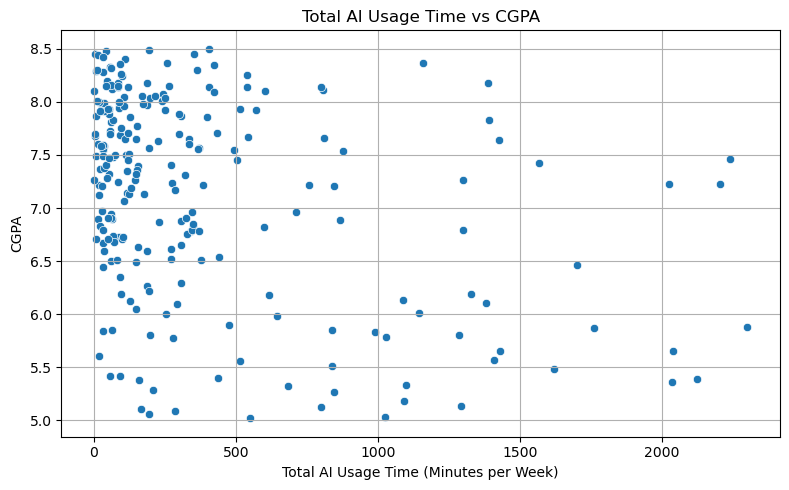

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Simple scatter to preview relationship
plt.figure(figsize=(8, 5))
sns.scatterplot(x=merged_df['Total_AI_Time'], y=merged_df['CGPA'])
plt.title("Total AI Usage Time vs CGPA")
plt.xlabel("Total AI Usage Time (Minutes per Week)")
plt.ylabel("CGPA")
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Pearson Correlation Test (Statistical Test)
We compute the Pearson correlation coefficient (r) and the associated p-value between:
- Total AI Usage Time (Minutes per Week)
- CGPA


In [9]:
from scipy.stats import pearsonr

# Pearson test for Total AI Time vs CGPA
r, p_value = pearsonr(df['Total_AI_Time'], df['CGPA'])
n = df.shape[0]
dfree = n - 2

print(f"Pearson Correlation Coefficient (r): {r:.4f}")
print(f"p-value: {p_value:.10f}")
print(f"Degrees of Freedom: {dfree}")

Pearson Correlation Coefficient (r): -0.3631
p-value: 0.0000000085
Degrees of Freedom: 235


## 5. Interpretation
- **Strength and Direction:** The moderate negative correlation ($r \approx -0.36$) suggests a statistically significant inverse linear relationship between Total AI Usage Time and CGPA.

- **Statistical Significance:** The p-value ($8.5 \times 10^{-9}$) is well below the standard significance level of $\alpha = 0.05$, so we *reject the null hypothesis*.

- **Conclusion:** This means that increased time spent using generative AI tools is statistically associated with a decrease in academic performance (CGPA) within this sample. While the correlation is moderate (meaning other factors also affect grades), the relationship is highly significant and not due to random chance.